In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import time

from scipy.signal import convolve2d
from tqdm import tqdm,trange

from numba import jit

In [2]:
class SimulationManager():
    def __init__(self,shape,defect_number,defect_size,well_depth,
                 ferroelectric_decay_power, ferroelectric_well_depth,
                 dipole_moment, surface_charge_well_depth):
        """
        shape: shape of the simulation, the number of cells to model in each
               direction
        defect_number: number of defects
        defect_size: the size of each defect
        well_depth: the effective depth of the double well potential
        ferroelectric_decay_power: how fast the ferroelectric effect decays
        ferroelectric_well_depth: how powerful the ferroelectric effect is
        dipole_moment: the magnitude of the dipole moment of each cell
        surface_charge_well_depth: the effective well depth due to the surface
                                   charges
        """
        #init some base things
        self.polarization = np.random.choice([-1,1],size=shape)
        self.defect_mask = np.zeros(shape) #zero = no defect, one = defect
        self.field_from_cells = np.zeros(shape) #electric field due to cells
        self.surface_charge_density = np.zeros(shape) #surface charge density
        self.intrinsic_electric_energy = np.zeros(shape)

        #assign defects
        for defect in range(defect_number):
            loc = np.array([np.int(np.random.randint(shape[0])),
                            np.int(np.random.randint(shape[1]))])
            for i in range(defect_size):
                self.defect_mask[loc[0],loc[1]] = 1
                self.polarization[loc[0],loc[1]] = 0
                direction = np.random.choice([-1,1,0],size=(2,),p=[0.4,0.4,0.2])
                loc += direction
                loc = np.mod(loc,shape)

        #set given values
        self.well_depth = well_depth
        self.ferroelectric_decay_power = ferroelectric_decay_power
        self.ferroelectric_well_depth = ferroelectric_well_depth
        self.dipole_moment = dipole_moment
        self.surface_charge_well_depth = surface_charge_well_depth

        #set default simulation values
        self.set_experiment_parameters()
        self.age = 0

        #for drawing purposes
        self.cmap = colors.ListedColormap(['black','red','white'])
        self.norm = colors.BoundaryNorm([-2,-0.5,0.5,2],self.cmap.N)
        self.shape = shape

        
    def set_experiment_parameters(self,electric_field_amplitude=1,
                                       electric_field_period=100,
                                       distance=10,
                                       electric_field_start_time=50,
                                       thermal_mean=0,
                                       thermal_std=0):
        self.distance = distance
        self.electric_field_amplitude = electric_field_amplitude
        self.electric_field_period = electric_field_period
        self.electric_field_start_time = electric_field_start_time
        
        self.thermal_mean = thermal_mean
        self.thermal_std = thermal_std

        if self.thermal_mean != 0:
            self.thermal_energy = np.full(self.shape,self.thermal_mean)
            thermal_distance = 1
            self.thermal_box = np.ones((thermal_distance,thermal_distance))/\
                               (2*thermal_distance+1)**2

        self.external_electric_field = 0


        #defining the boxes used for calculating the intrinsic effects
        a0 = np.arange(-self.distance,self.distance+1)
        a1 = np.arange(-self.distance,self.distance+1)
        A0,A1 = np.meshgrid(a0,a1)
        ferroelectric_box = np.absolute(A0)**self.ferroelectric_decay_power + \
                            np.absolute(A1)**self.ferroelectric_decay_power
        ferroelectric_box = np.where(ferroelectric_box != 0, ferroelectric_box, 1)
        ferroelectric_box = 1/ferroelectric_box
        ferroelectric_box *= self.ferroelectric_well_depth
        surface_charge_box = np.sqrt(A0**2 + A1**2 )
        surface_charge_box = np.where(surface_charge_box != 0, surface_charge_box, 1)
        surface_charge_box = self.surface_charge_well_depth * 1/surface_charge_box
        self.ferroelectric_box = ferroelectric_box
        self.surface_charge_box = surface_charge_box
    @jit
    def calculate_polarization(self):
        """
        Effects to account for:
            1) the energy barrier between wells
            2) exterior electric field
            3) nearby cells creating an electric field
            4) surface charge buildup creating a depolarization field
        Most, if not all, of these effects are due to an electric field. The 
        other cells can be modeled as dipoles, with electric potential that
        decays as 1/r^2 
        """
        self.update_intrisic_electric_field()
        down = self.polarization < 0
        up   = self.polarization > 0
        if self.thermal_mean == 0:
            #these are where the model has the system in the up position and
            #staying there, or down and changing, etc
            down_and_stay = np.logical_and(down,self.intrinsic_electric_energy < self.well_depth -
                                        self.external_electric_field)
            down_and_change=np.logical_and(down,self.intrinsic_electric_energy > self.well_depth -
                                        self.external_electric_field)
            up_and_stay = np.logical_and(up,-self.intrinsic_electric_energy < self.well_depth +
                                        self.external_electric_field)
            up_and_change=np.logical_and(up,-self.intrinsic_electric_energy > self.well_depth +
                                        self.external_electric_field)
            #since we either stay the same or change, we can do it like this
            self.polarization = np.where(np.logical_or(down_and_stay,up_and_stay),
                                        self.polarization,
                                        -1*self.polarization)
                                        #0)
        else:
            down_and_stay = np.logical_and(down,self.well_depth - self.external_electric_field -\
                                           self.intrinsic_electric_energy > self.thermal_energy)
            up_and_stay = np.logical_and(up,self.well_depth + self.external_electric_field + \
                                         self.intrinsic_electric_energy > self.thermal_energy)
            # down_to_up_possible = np.logical_and(down,~down_and_stay)
            # up_to_down_possible = np.logical_and(up,~up_and_stay)
            extra_energy = self.thermal_energy > self.well_depth + \
                                            np.absolute(self.external_electric_field)
            # down_to_up = np.logical_and(down_to_up_possible,~extra_energy)
            # up_to_down = np.logical_and(up_to_down_possible,~extra_energy)
            # up = logical_or(down_to_up,up_and_stay)
            # down = logical_or(down_and_stay,up_to_down)
            polarization = np.where(np.logical_or(up_and_stay,down_and_stay),
                                    self.polarization,-1*self.polarization)
            
            #proba depends on well depth, the chance to be low = low/(low+high)
            down_height = -self.well_depth + self.external_electric_field
            up_height = -self.well_depth - self.external_electric_field
            chance_down = down_height**2/(down_height**2+up_height**2)
            #print("test")
            random = np.random.choice([-1,1],size=self.shape,p=[chance_down,1-chance_down])
            #print(random.shape,polarization.shape,extra_energy)
            self.polarization = np.where(extra_energy,random,polarization)

        #last step is to set defects to zero
        self.polarization = self.polarization * ( 1 - self.defect_mask)
    @jit
    def update_intrisic_electric_field(self):
        #the question is how far to calculate both the ferroelectric effect and
        #the surface charge density. the ferroelectric range
        #energy due to a charge falls like 1/r
        #so that's the falloff i will use for the surface charge effect

        fe_effect = convolve2d(self.polarization,self.ferroelectric_box,mode='same')
        surface_effect = convolve2d(self.polarization,self.surface_charge_box,mode='same')
        #positive pushes in the positive direction
        #so more positive surface charges pushes it into the down polarization
        self.intrinsic_electric_energy = fe_effect - surface_effect
    def update_external_electric_field(self):
        if self.age > self.electric_field_start_time:
            self.external_electric_field = self.electric_field_amplitude * \
                                           np.sin(2*np.pi/self.electric_field_period * \
                                           self.age)
    def update_thermal_energy(self):
        if self.thermal_mean != 0:
            self.thermal_energy = convolve2d(self.thermal_energy,self.thermal_box,mode='same',
                                             fillvalue=self.thermal_mean)
            change = np.random.normal(0,self.thermal_std,self.shape)
            self.thermal_energy += change

    def draw_single_image(self):
        plt.figure()
        plt.imshow(self.polarization,cmap=self.cmap,norm=self.norm)
        plt.show()
    def tick(self):
        self.update_intrisic_electric_field()
        self.update_external_electric_field()
        self.update_thermal_energy()
        self.calculate_polarization()
        self.age += 1
        #self.draw_single_image()
    def animate(self,frame,fig):
        display_thermal_energy = False
        if display_thermal_energy:
            fig.clear()
            plt.subplot(211)
            plt.title(str(self.age)+", E field: {}".format(np.round(self.external_electric_field)))
            plt.imshow(self.polarization,cmap=self.cmap,norm=self.norm)
            plt.colorbar()
            plt.subplot(212)
            plt.imshow(self.thermal_energy,cmap='jet')
            plt.colorbar()
        else:
            fig.clear()
            plt.title(str(self.age)+", E field: {}".format(np.round(self.external_electric_field)))
            plt.imshow(self.polarization,cmap=self.cmap,norm=self.norm)

        self.tick()
    def simulate(self,length,save=''):
        t_start = time.time()
        data_holder = np.zeros((length,self.shape[0],self.shape[1]))
        print("Running the simulation")
        for frame in trange(length):
            data_holder[frame,:,:] = self.polarization.copy()
            self.tick()
        print("Calculating the fft")
        data_holder = np.fft.fft2(data_holder)
        print("Calculating the two time correlation")
        ttc = np.zeros((length,length))
        data_holder = np.absolute(data_holder)
        for i in trange(length):
            for j in range(i):
                normalization = np.average(data_holder[i,:,:])*np.average(data_holder[j,:,:])
                correlation = np.average(data_holder[i,:,:]*data_holder[j,:,:])
                value = correlation/normalization
                ttc[j,i] = value
                ttc[i,j] = value
        print("Total time taken: {}".format(time.time()-t_start))
        if save != '':
            print("Saving with filename: " + save)
            np.savetxt(save,ttc)
        print("Displaying two time correlation image")
        plt.figure()
        plt.imshow(ttc,cmap='jet',origin='lower')
        plt.show()

In [3]:
shape = (100,100)
num_defects = 0
defect_size = 20
well_depth = 10
fe_decay_power = 3
fe_well_depth = 8
dipole_moment = 1
surface_well_depth = 2

efield_start = 100
efield_amp = 25
efield_period = 1000

thermal_mean = 7
thermal_std = 1

length=1000

In [4]:
model = SimulationManager(shape,num_defects,defect_size,well_depth,fe_decay_power,
                          fe_well_depth,dipole_moment,surface_well_depth)

model.set_experiment_parameters(electric_field_amplitude=efield_amp,
                                electric_field_period=efield_period,
                                electric_field_start_time=efield_start,
                                thermal_mean=thermal_mean,
                                thermal_std=thermal_std)

In [5]:
fn = ("shape_{}_ndefect_{}_defectsize_{}_welldepth_{}_fepower_{}_fedepth_{}"
     "_surfacedepth_{}_estart_{}_eamp_{}_eperiod_{}_length_{}_time_{}_"
     "thermalmean_{}_thermalstd_{}_.txt"\
    .format(shape[0],num_defects,defect_size,well_depth,fe_decay_power,
    fe_well_depth,surface_well_depth,efield_start,efield_amp,efield_period,
    length,np.rint(time.time()),thermal_mean,thermal_std))

In [6]:
for i in trange(1500):
    model.tick()

# model.simulate(length,save=fn)

  0%|          | 0/1500 [00:00<?, ?it/s]<ipython-input-2-6b3a553c221f>:147: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "update_intrisic_electric_field" failed type inference due to: Untyped global name 'convolve2d': cannot determine Numba type of <class 'function'>

File "<ipython-input-2-6b3a553c221f>", line 154:
    def update_intrisic_electric_field(self):
        <source elided>

        fe_effect = convolve2d(self.polarization,self.ferroelectric_box,mode='same')
        ^

  @jit
/Users/Rui/anaconda3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "update_intrisic_electric_field" was compiled in object mode without forceobj=True.

File "<ipython-input-2-6b3a553c221f>", line 148:
    @jit
    def update_intrisic_electric_field(self):
    ^

  self.func_ir.loc))
/Users/Rui/anaconda3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nopython compilation pat

<IPython.core.display.Javascript object>


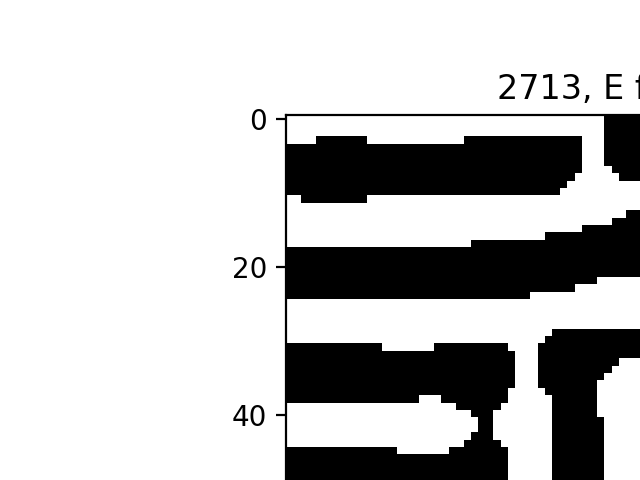

In [11]:
%matplotlib notebook
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure()

ani = animation.FuncAnimation(fig,model.animate,frames=100,fargs=[fig],interval=20)

#ani.save('im.mp4', writer=writer)
#plt.show()

In [12]:
ani.save('test.gif', writer='imagemagick', fps=10)

In [13]:
from IPython.display import HTML, Image
Image(url='test.gif')